# Deep Learning & Art: Neural Style Transfer

В большинстве алгоритмов, которые вы изучали на данный момент, происходит минимизация функции потерь, чтобы получить набор оптимальных параметров. В NST функция потерь минимизируется для получения значений пикселей.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras.backend as K

gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)
session = tf.Session(config=config) 
K.set_session(session)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU Not Found!')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

# Постановка задачи

__Задача состоит в следующем__: имеются 2 изображения, которые нужно "слить" в одно. Причем мы хотим сохранить содержание одного из них (обозначим как изображение $C$ ). У другого изображения хотим сохранить стиль (обозначим $S$ ). И, наконец, изображение $G$, которое мы инициализируем случайным шумом. Оно будет изменяться в процессе работы алгоритма (значения пикслей будут обновляться в процессе минимизации функции потерь, как веса в обычной сети) и в результате получится картинка, совмещающая содержание $C$ и стиль $S$.

<img src="images/style_transfer.jpeg">

# Transfer learning

Для решения будем использовать предобученную на другой задаче (ImageNet) сеть, в статье предлагают VGG – ее и возьмем.

```python
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
```

Модель можно скачать по ссылке: http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

# Построение системы переноса стиля

Система переноса стиля состоит из следующих частей:
* Content loss function – $J_{content}(C,G)$ – показывает, насколько сгенерированная картинка отличается по содержанию
* Style loss function – $J_{style}(S,G)$ – показывает, насколько сгенерированная картинка отличается по стилю
* $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$ – все вместе

## Вычисляем сontent loss

Как мы знаем, менее глубокие слои сверточной сети распознают низкоуровневые признаки (такие как грани и простые фигуры), а более глубокие – высокоуровневые (сложные фигуры, объекты). 

Мы хотим, чтобы новая картинка сохранила содержание входного изображения $C$. Выбираем один из слоев сети, активации которого будут представлять содержание изображения (на практике получено, что этот слой должен быть не слишком глубоким и не слишком поверхностным).

Предположим, мы выбрали какой-то слой. Теперь нужно прогнать изображение $C$ через сеть (VGG), получить активации $a^{(C)}$ с выбранного слоя. Это будет тензор размером  $n_H \times n_W \times n_C$. Тоже самое для изображения $G$. Content loss определяется следующим образом:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$


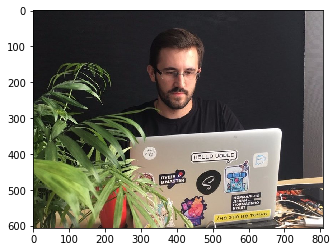

In [3]:
content_image = scipy.misc.imread("images/olferuk_content.jpg")
imshow(content_image);

In [4]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G))) / (4 * n_H * n_W * n_C)
    return J_content

<font color='blue'>
**Надо запомнить**:
- Content loss берет активации скрытого слоя сверточной сети и измеряет насколько $a^{(C)}$ и $a^{(G)}$ отличаются.
- Когда мы будем минимизировать content loss, мы будем приближать содержание $G$ к $C$.

## Вычисляем style cost

Для примера будем использовать такую картинку:

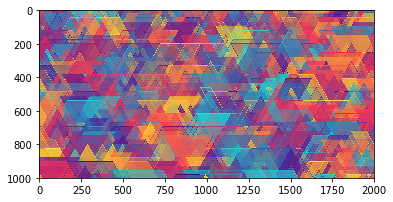

In [5]:
style_image = scipy.misc.imread("images/olferuk_style.png")
imshow(style_image);

### Style matrix

Style matrix по другому называется матрица Грама. В линейной алгебре матрица Грама для множества векторов $(v_{1},\dots ,v_{n})$ определяется как матрица скалярных произведений, где ${\displaystyle Gr_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. Другими словами $Gr_{ij}$ показывает насколько $v_i$ похож на $v_j$: если они сильно схожи, то и скалярное произведение $Gr_{ij}$ будет большим ([если не поняли почему так](https://en.wikipedia.org/wiki/Cosine_similarity)).

В NST матрица Грама вычисляется как произведение "развернутой" матрицы активаций с самой собой транспонированной. Происходит это следующим образом:

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

И затем вычисляется Style matrix:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

Получается матрица размера $(n_C,n_C)$, где $n_C$ – количество фильтров. Элемент $G_{ij}$ показывает насоклько похожи активации фильтра $i$ на активации фильтра $j$.

Диагональные элементы $G_{ii}$ показывают насколько сильно активировался фильтр. Например, если $i$-й фильтр отвечает за распознаваине горизонтальных линий, $G_{ii}$ показывает насколько часто встречаются горизонтальные линии.

In [6]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, A, transpose_b=True)
    return GA

### Style cost

Наша цель – минимизировать различие между матрицами Грама изображений $S$ и $G$. Для одного скрытого слоя $l$ style cost вычисляется следующим образом:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(Gr^{(S)}_{ij} - Gr^{(G)}_{ij})^2\tag{2} $$

In [7]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S[0], [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G[0], [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4 * n_C**2 * (n_H*n_W)**2)
    
    return J_style_layer

### Style Weights

Пока что мы захватили информацию о стиле только с одного слоя. Но можно взять несколько слоев, чтобы улучшить результат (вспоминаем про низкоуровневые-высокоуровневые признаки).

In [8]:
# How do you choose the coefficients for each layer? 
# The deeper layers capture higher-level concepts, 
# and the features in the deeper layers are less localized in the image relative to each other. 
# So if you want the generated image to softly follow the style image, 
# try choosing larger weights for deeper layers and smaller weights for the first layers. 
# In contrast, if you want the generated image to strongly follow the style image, 
# try choosing smaller weights for deeper layers and larger weights for the first layers
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

Вычисляем взвешенную сумму style costs с различных слоев:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

Значения $\lambda^{[l]}$ берутся из `STYLE_LAYERS`. 

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        # a_G is a tensor and hasn't been evaluated yet. 
        # It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

<font color='blue'>
**Надо запомнить**:
- Стиль изображения можно представить в виде матрицы Грама от активаций скрытого слоя. В отличие от представления содержания, где достаточно лишь одного слоя, – для стиля можно использовать несколько слоев, результаты будут лучше. 
- Когда мы будем минимизировать style loss, мы будем приближать стиль $G$ к $S$.
</font color='blue'>

### Total cost, который мы будем минимизировать

 $$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

$\alpha$ и $\beta$ позволяют регулировать соотношение между стилем и содержанием (гиперпараметры).

In [10]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    return J

## Решаем задачу оптимизации

Шаги алгоритма:
<font color='purple'>

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>
.

In [11]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

# load, reshape, and normalize our "content" image 
content_image = scipy.misc.imread('images/olferuk_content.jpg')
content_image = scipy.misc.imresize(content_image, (300, 400))
content_image = reshape_and_normalize_image(content_image)

# load, reshape and normalize our "style" image
style_image = scipy.misc.imread("images/olferuk_style.png", mode='RGB')
style_image = scipy.misc.imresize(style_image, (300, 400))
style_image = reshape_and_normalize_image(style_image)

Инициализируем $G$ добавлением шума к $C$. Это ускорит сходимость. 

In [12]:
generated_image = generate_noise_image(content_image)

In [13]:
# load the VGG16 model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [14]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out
# At this point, a_G is a tensor and hasn't been evaluated. 
# It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [15]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [16]:
J = total_cost(J_content, J_style)

In [17]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

In [18]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image[0])
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [19]:
new_image = model_nn(sess, generated_image, num_iterations=500)

Iteration 0 :
total cost = 1.91769e+10
content cost = 9749.19
style cost = 4.7942e+08
Iteration 20 :
total cost = 2.06213e+09
content cost = 22628.1
style cost = 5.15475e+07
Iteration 40 :
total cost = 6.04222e+08
content cost = 23012.0
style cost = 1.50998e+07
Iteration 60 :
total cost = 3.21309e+08
content cost = 23822.6
style cost = 8.02678e+06
Iteration 80 :
total cost = 2.22768e+08
content cost = 24294.2
style cost = 5.56313e+06
Iteration 100 :
total cost = 1.73023e+08
content cost = 24578.8
style cost = 4.31944e+06
Iteration 120 :
total cost = 1.41335e+08
content cost = 24788.5
style cost = 3.52718e+06
Iteration 140 :
total cost = 1.1858e+08
content cost = 24963.6
style cost = 2.95825e+06
Iteration 160 :
total cost = 1.01253e+08
content cost = 25108.1
style cost = 2.52505e+06
Iteration 180 :
total cost = 8.76783e+07
content cost = 25232.0
style cost = 2.18565e+06
Iteration 200 :
total cost = 7.6786e+07
content cost = 25342.5
style cost = 1.91331e+06
Iteration 220 :
total cost = 6

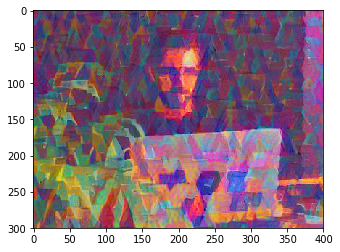

In [20]:
plt.imshow(plt.imread('output/generated_image.jpg'));

## Домашка
- Попробуйте со своими картинками
- Поэксперементируйте с весами `STYLE_LAYERS`
- Поэкспериментируйте с гиперпараметрами $\alpha$ и $\beta$
- Результатами поделитесь в чате

## Ссылки:

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)